In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import random

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

SEEDS = [202]
EPOCHS_MAIN = 15
BATCH_SIZE_MAIN = 64
LR = 0.001

BATCH_SIZES_TEST = [8, 16, 32, 64, 128]
EPOCHS_SENSITIVITY = 10

sns.set_theme(style="whitegrid", context="paper")
COLORS = {'BN': '#1f77b4', 'LN': '#ff7f0e'}

Running on: cuda


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def get_loaders(batch_size):
    """Returns dataloaders for a specific batch size."""
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, norm_type='bn'):
        super(SimpleCNN, self).__init__()
        self.norm_type = norm_type

        def get_norm(channels):
            if norm_type == 'bn':
                return nn.BatchNorm2d(channels)
            elif norm_type == 'ln':
                return nn.GroupNorm(1, channels)
            return nn.Identity()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.norm1 = get_norm(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = get_norm(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm3 = get_norm(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        # Classifier
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.norm1(self.conv1(x))))
        x = self.pool2(self.relu2(self.norm2(self.conv2(x))))
        x = self.pool3(self.relu3(self.norm3(self.conv3(x))))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def run_training(norm_type, batch_size, seed, epochs, capture_grads=False):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    train_loader, test_loader = get_loaders(batch_size)
    model = SimpleCNN(norm_type).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'global_grad_norm': [],
        'layer_grads': {}
    }

    capture_epochs = [1, epochs//2 + 1, epochs] if capture_grads else []

    global_step = 0
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        if epoch in capture_epochs:
            history['layer_grads'][epoch] = {name: [] for name, _ in model.named_parameters() if 'weight' in name and 'conv' in name}

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            if capture_grads:
                total_norm = 0.0
                for p in model.parameters():
                    if p.grad is not None:
                        total_norm += p.grad.data.norm(2).item() ** 2
                total_norm = total_norm ** 0.5
                history['global_grad_norm'].append(total_norm)

            if epoch in capture_epochs and i == len(train_loader)//2:
                for name, p in model.named_parameters():
                    if 'weight' in name and 'conv' in name and p.grad is not None:
                        grads = p.grad.detach().cpu().numpy().flatten()
                        sample = np.random.choice(grads, min(len(grads), 500), replace=False)
                        history['layer_grads'][epoch][name] = sample

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            global_step += 1

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        history['train_loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['train_acc'].append(100 * correct_train / total_train)
        history['val_acc'].append(100 * correct_val / total_val)

        print(f"[{norm_type.upper()}|Seed {seed}|Ep {epoch}] Train Loss: {history['train_loss'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.2f}%")

    return history

In [11]:
main_results = {'bn': [], 'ln': []}
print(f"Starting Main Experiment (Batch Size: {BATCH_SIZE_MAIN})...")

for seed in SEEDS:
    for norm in ['bn', 'ln']:
        res = run_training(norm, BATCH_SIZE_MAIN, seed, EPOCHS_MAIN, capture_grads=True)
        main_results[norm].append(res)

Starting Main Experiment (Batch Size: 64)...
[BN|Seed 202|Ep 1] Train Loss: 1.1507 | Val Acc: 64.04%
[BN|Seed 202|Ep 2] Train Loss: 0.8105 | Val Acc: 73.13%
[BN|Seed 202|Ep 3] Train Loss: 0.6843 | Val Acc: 74.41%
[BN|Seed 202|Ep 4] Train Loss: 0.5936 | Val Acc: 74.09%
[BN|Seed 202|Ep 5] Train Loss: 0.5244 | Val Acc: 75.94%
[BN|Seed 202|Ep 6] Train Loss: 0.4523 | Val Acc: 76.76%
[BN|Seed 202|Ep 7] Train Loss: 0.3991 | Val Acc: 76.05%
[BN|Seed 202|Ep 8] Train Loss: 0.3498 | Val Acc: 77.52%
[BN|Seed 202|Ep 9] Train Loss: 0.2939 | Val Acc: 77.92%
[BN|Seed 202|Ep 10] Train Loss: 0.2541 | Val Acc: 77.56%
[BN|Seed 202|Ep 11] Train Loss: 0.2263 | Val Acc: 76.77%
[BN|Seed 202|Ep 12] Train Loss: 0.1872 | Val Acc: 76.73%
[BN|Seed 202|Ep 13] Train Loss: 0.1674 | Val Acc: 76.64%
[BN|Seed 202|Ep 14] Train Loss: 0.1362 | Val Acc: 77.77%
[BN|Seed 202|Ep 15] Train Loss: 0.1339 | Val Acc: 77.04%
[LN|Seed 202|Ep 1] Train Loss: 1.3280 | Val Acc: 60.39%
[LN|Seed 202|Ep 2] Train Loss: 0.9081 | Val Acc: 71.1

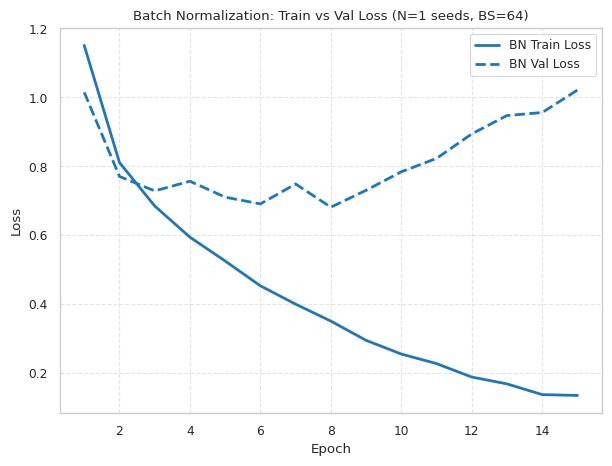

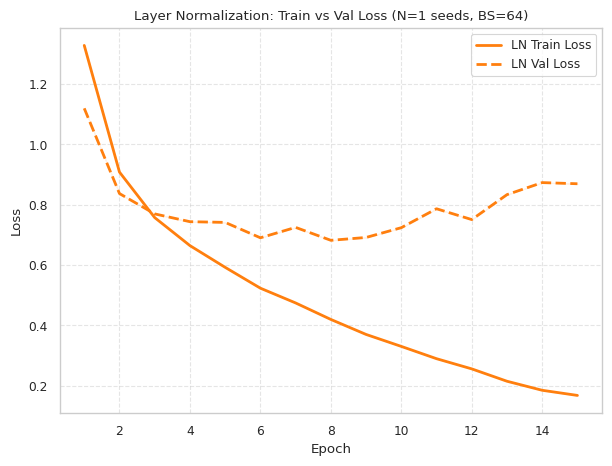

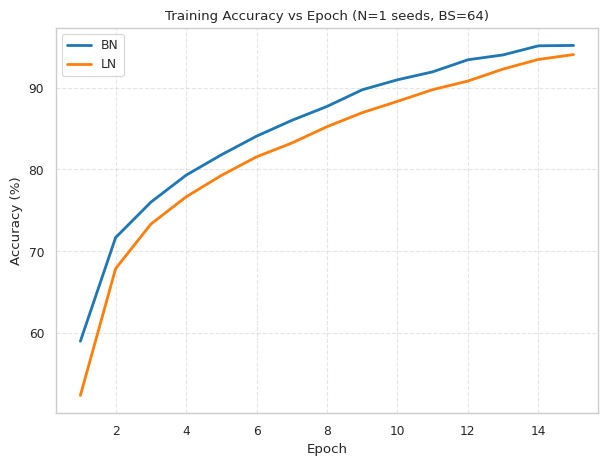

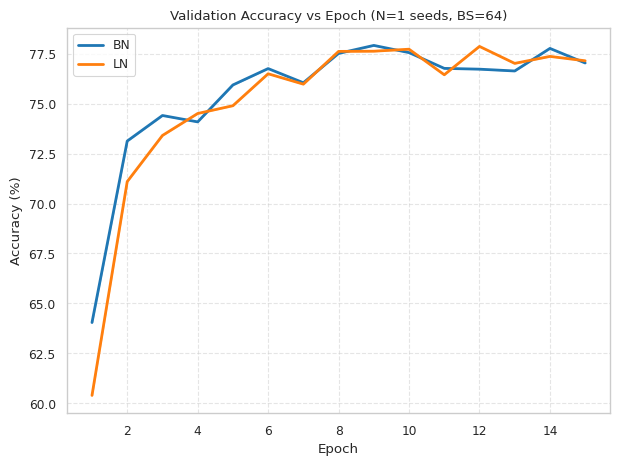

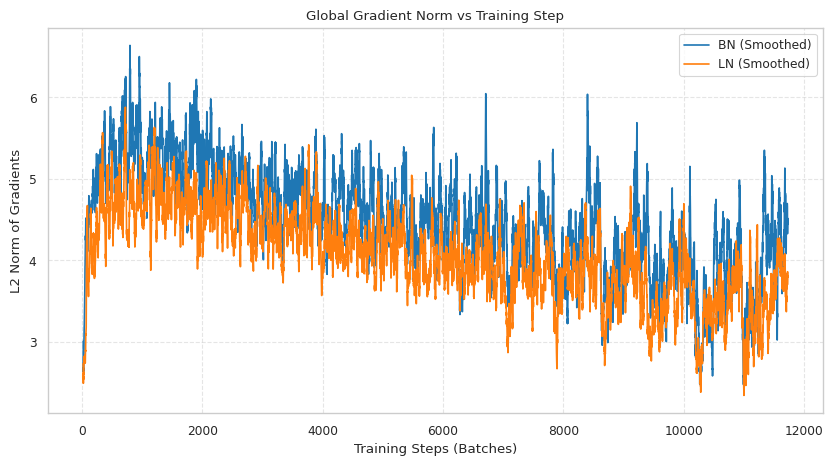

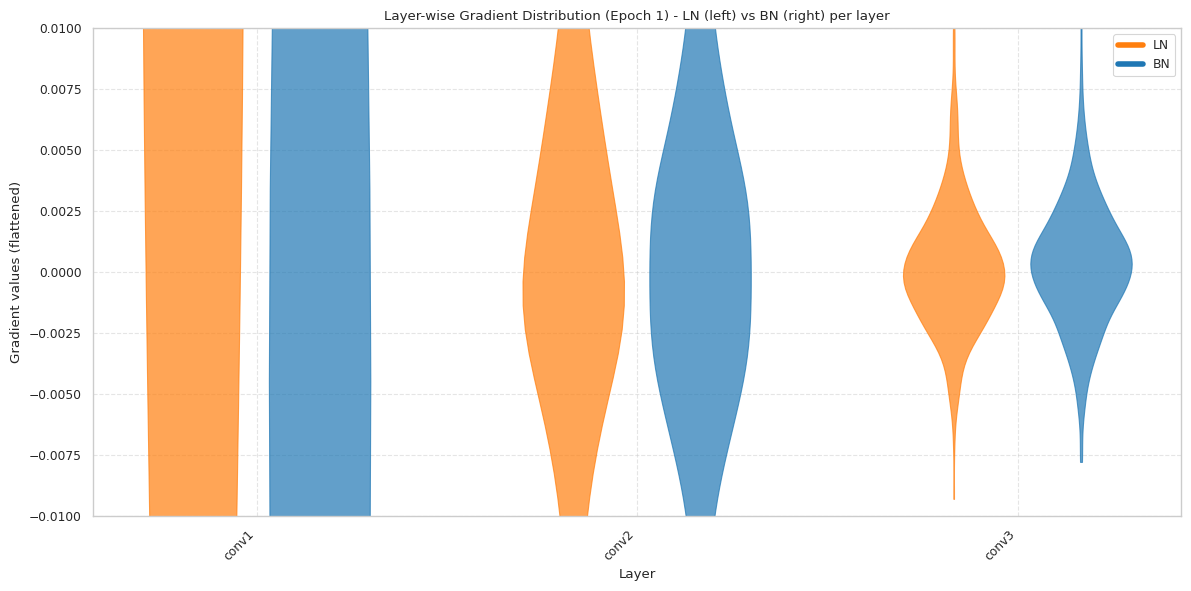

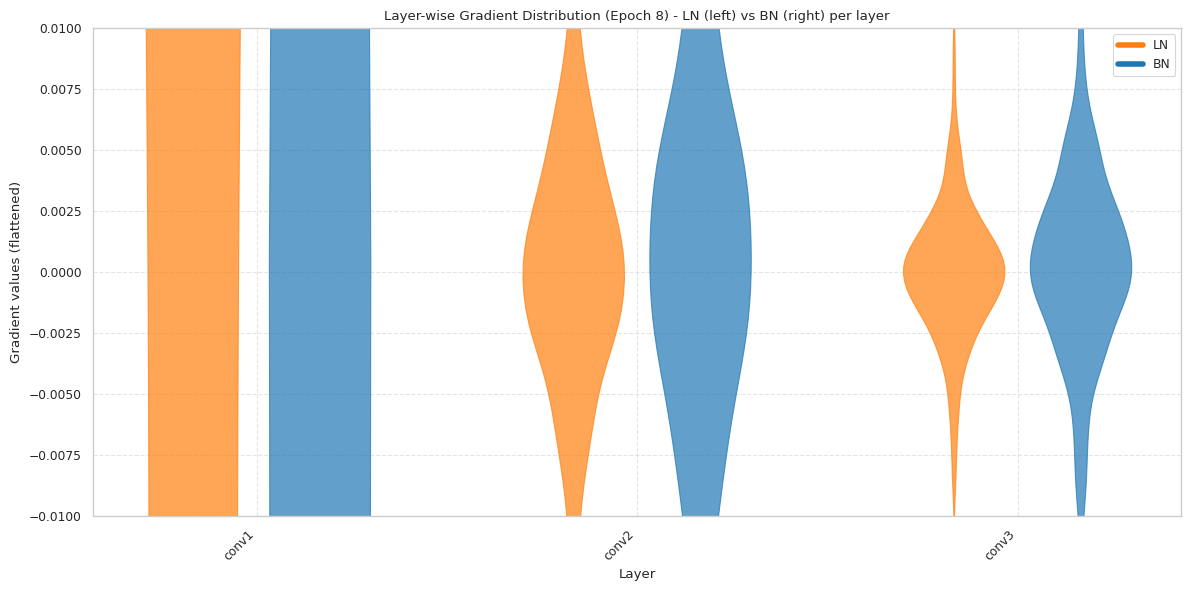

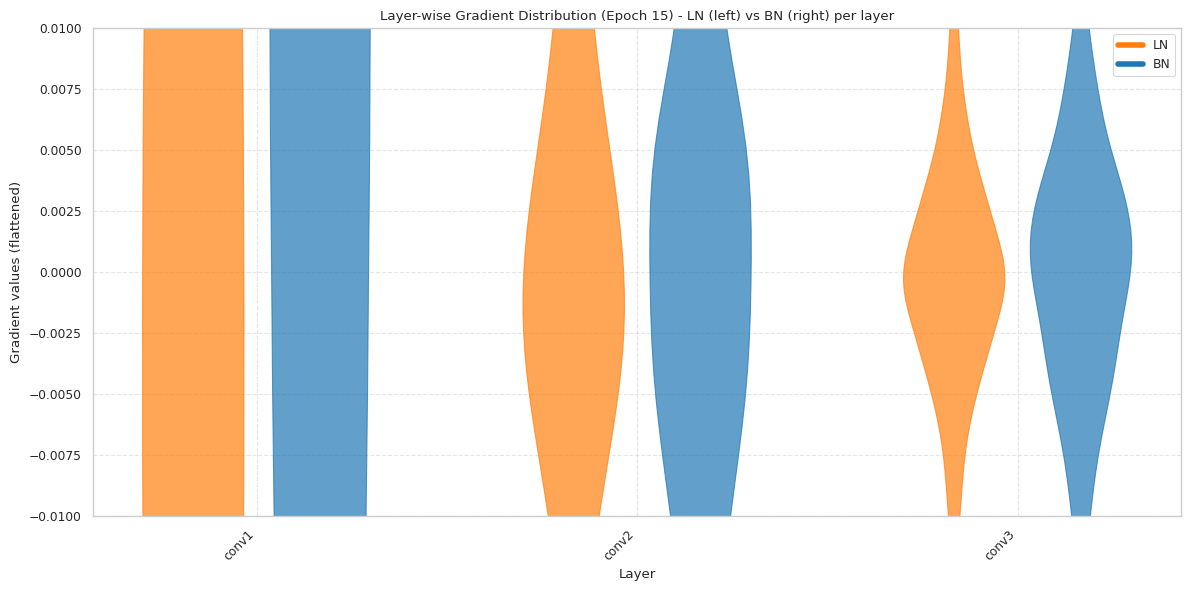

In [22]:
def get_mean_std(results, metric):
    data = {}
    for norm in ['bn', 'ln']:
        arr = np.array([r[metric] for r in results[norm]])
        if np.all(arr.std(axis=0) == 0):
            data[norm] = (arr.mean(axis=0), np.zeros_like(arr.mean(axis=0)))
        else:
            data[norm] = (arr.mean(axis=0), arr.std(axis=0))
    return data

epochs_range = range(1, EPOCHS_MAIN + 1)

plt.figure(figsize=(7, 5))
train_loss_bn_data = get_mean_std(main_results, 'train_loss')['bn']
val_loss_bn_data = get_mean_std(main_results, 'val_loss')['bn']

plt.plot(epochs_range, train_loss_bn_data[0], label='BN Train Loss', color=COLORS['BN'], linestyle='-', linewidth=2)
plt.fill_between(epochs_range, train_loss_bn_data[0] - train_loss_bn_data[1], train_loss_bn_data[0] + train_loss_bn_data[1], color=COLORS['BN'], alpha=0.1)

plt.plot(epochs_range, val_loss_bn_data[0], label='BN Val Loss', color=COLORS['BN'], linestyle='--', linewidth=2)
plt.fill_between(epochs_range, val_loss_bn_data[0] - val_loss_bn_data[1], val_loss_bn_data[0] + val_loss_bn_data[1], color=COLORS['BN'], alpha=0.1)

plt.title(f"Batch Normalization: Train vs Val Loss (N={len(SEEDS)} seeds, BS={BATCH_SIZE_MAIN})") # Adding suptitle-like info to title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

plt.figure(figsize=(7, 5))
train_loss_ln_data = get_mean_std(main_results, 'train_loss')['ln']
val_loss_ln_data = get_mean_std(main_results, 'val_loss')['ln']

plt.plot(epochs_range, train_loss_ln_data[0], label='LN Train Loss', color=COLORS['LN'], linestyle='-', linewidth=2)
plt.fill_between(epochs_range, train_loss_ln_data[0] - train_loss_ln_data[1], train_loss_ln_data[0] + train_loss_ln_data[1], color=COLORS['LN'], alpha=0.1)

plt.plot(epochs_range, val_loss_ln_data[0], label='LN Val Loss', color=COLORS['LN'], linestyle='--', linewidth=2)
plt.fill_between(epochs_range, val_loss_ln_data[0] - val_loss_ln_data[1], val_loss_ln_data[0] + val_loss_ln_data[1], color=COLORS['LN'], alpha=0.1)

plt.title(f"Layer Normalization: Train vs Val Loss (N={len(SEEDS)} seeds, BS={BATCH_SIZE_MAIN})") # Adding suptitle-like info to title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


plt.figure(figsize=(7, 5))
train_acc_data = get_mean_std(main_results, 'train_acc')

for norm in ['bn', 'ln']:
    mean_train, std_train = train_acc_data[norm]
    plt.plot(epochs_range, mean_train, label=f'{norm.upper()}', color=COLORS[norm.upper()], linewidth=2)
    plt.fill_between(epochs_range, mean_train - std_train, mean_train + std_train, color=COLORS[norm.upper()], alpha=0.2)

plt.title(f"Training Accuracy vs Epoch (N={len(SEEDS)} seeds, BS={BATCH_SIZE_MAIN})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

plt.figure(figsize=(7, 5))
val_acc_data = get_mean_std(main_results, 'val_acc')

for norm in ['bn', 'ln']:
    mean_val, std_val = val_acc_data[norm]
    plt.plot(epochs_range, mean_val, label=f'{norm.upper()}', color=COLORS[norm.upper()], linewidth=2)
    plt.fill_between(epochs_range, mean_val - std_val, mean_val + std_val, color=COLORS[norm.upper()], alpha=0.2)

plt.title(f"Validation Accuracy vs Epoch (N={len(SEEDS)} seeds, BS={BATCH_SIZE_MAIN})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

plt.figure(figsize=(10, 5))
for norm in ['bn', 'ln']:
    grad_norms = main_results[norm][0]['global_grad_norm']
    series = pd.Series(grad_norms).rolling(window=20).mean()
    plt.plot(series, label=f'{norm.upper()} (Smoothed)', color=COLORS[norm.upper()])

plt.title("Global Gradient Norm vs Training Step")
plt.xlabel("Training Steps (Batches)")
plt.ylabel("L2 Norm of Gradients")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


def plot_layer_grad_violin(hist_snapshots_ln, hist_snapshots_bn):
    epochs = sorted(set(hist_snapshots_ln.keys()) & set(hist_snapshots_bn.keys()))
    for epoch in epochs:
        data_ln = hist_snapshots_ln[epoch]
        data_bn = hist_snapshots_bn[epoch]
        layers = sorted(set(data_ln.keys()) & set(data_bn.keys()))

        fig, ax = plt.subplots(figsize=(12, 6))
        positions = []
        violin_data = []
        pos = 1
        ticks = []
        layer_labels = []

        for layer in layers:
            violin_data.append(data_ln[layer])
            positions.append(pos)
            pos += 1
            violin_data.append(data_bn[layer])
            positions.append(pos)
            pos += 2
            ticks.append(pos - 2.5)
            layer_labels.append(layer.replace('.weight', ''))

        parts = ax.violinplot(violin_data, positions=positions, showextrema=False, widths=0.8)

        for i, body in enumerate(parts['bodies']):
            if i % 2 == 0:
                body.set_facecolor(COLORS['LN'])
                body.set_edgecolor(COLORS['LN'])
            else:
                body.set_facecolor(COLORS['BN'])
                body.set_edgecolor(COLORS['BN'])
            body.set_alpha(0.7)

        ax.set_xticks(ticks)
        ax.set_xticklabels(layer_labels, rotation=45, ha="right")
        ax.set_title(f"Layer-wise Gradient Distribution (Epoch {epoch}) - LN (left) vs BN (right) per layer")
        ax.set_ylabel("Gradient values (flattened)")
        ax.set_xlabel("Layer")
        ax.set_ylim(-0.01, 0.01)
        ax.grid(True, which="both", ls="--", alpha=0.5)

        legend_handles = [plt.Line2D([0], [0], color=COLORS['LN'], lw=4, label='LN'),
                          plt.Line2D([0], [0], color=COLORS['BN'], lw=4, label='BN')]
        ax.legend(handles=legend_handles, loc='upper right')

        plt.tight_layout()
        plt.show()


hist_snapshots_ln = main_results['ln'][0]['layer_grads']
hist_snapshots_bn = main_results['bn'][0]['layer_grads']

plot_layer_grad_violin(hist_snapshots_ln, hist_snapshots_bn)


In [19]:
sensitivity_results = []
print("\nStarting Batch Size Sensitivity Experiment...")

for bs in tqdm(BATCH_SIZES_TEST):
    for norm in ['bn', 'ln']:
        res = run_training(norm, bs, seed=42, epochs=EPOCHS_SENSITIVITY, capture_grads=False)
        sensitivity_results.append({
            'Batch Size': bs,
            'Norm': norm.upper(),
            'Final Val Acc': res['val_acc'][-1]
        })

df_sensitivity = pd.DataFrame(sensitivity_results)


Starting Batch Size Sensitivity Experiment...


  0%|          | 0/5 [00:00<?, ?it/s]

[BN|Seed 42|Ep 1] Train Loss: 1.2323 | Val Acc: 66.17%
[BN|Seed 42|Ep 2] Train Loss: 0.8607 | Val Acc: 70.35%
[BN|Seed 42|Ep 3] Train Loss: 0.7144 | Val Acc: 74.71%
[BN|Seed 42|Ep 4] Train Loss: 0.6129 | Val Acc: 76.58%
[BN|Seed 42|Ep 5] Train Loss: 0.5296 | Val Acc: 77.31%
[BN|Seed 42|Ep 6] Train Loss: 0.4636 | Val Acc: 77.10%
[BN|Seed 42|Ep 7] Train Loss: 0.4041 | Val Acc: 77.35%
[BN|Seed 42|Ep 8] Train Loss: 0.3546 | Val Acc: 76.23%
[BN|Seed 42|Ep 9] Train Loss: 0.3141 | Val Acc: 77.48%
[BN|Seed 42|Ep 10] Train Loss: 0.2826 | Val Acc: 77.10%
[LN|Seed 42|Ep 1] Train Loss: 1.3334 | Val Acc: 64.89%
[LN|Seed 42|Ep 2] Train Loss: 0.8901 | Val Acc: 68.78%
[LN|Seed 42|Ep 3] Train Loss: 0.7308 | Val Acc: 74.58%
[LN|Seed 42|Ep 4] Train Loss: 0.6260 | Val Acc: 75.27%
[LN|Seed 42|Ep 5] Train Loss: 0.5410 | Val Acc: 76.43%
[LN|Seed 42|Ep 6] Train Loss: 0.4677 | Val Acc: 76.53%
[LN|Seed 42|Ep 7] Train Loss: 0.4101 | Val Acc: 77.02%
[LN|Seed 42|Ep 8] Train Loss: 0.3525 | Val Acc: 76.79%
[LN|Seed 

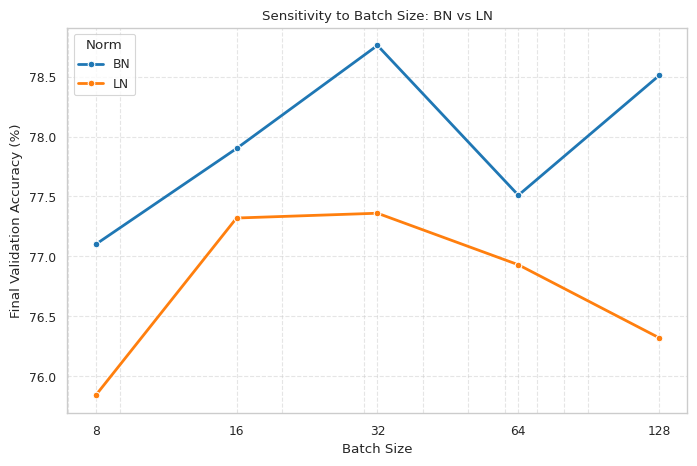

In [20]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_sensitivity, x='Batch Size', y='Final Val Acc', hue='Norm',
             palette=COLORS, marker='o', linewidth=2)
plt.xscale('log')
plt.xticks(BATCH_SIZES_TEST, BATCH_SIZES_TEST)
plt.title("Sensitivity to Batch Size: BN vs LN")
plt.ylabel("Final Validation Accuracy (%)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()